In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
import torch

sys.path.append('..')
from src.utils import *
from src.models import *
from src.configs import *

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
rcParams.update(fig_params)

import warnings

%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

## Load experiments file

In [2]:
FILENAME = 'Experiments_MASSIVE.xlsx'

In [5]:
exp_df = pd.read_excel(os.path.join('..', 'experiments', FILENAME), dtype=FORMAT)
exp_df.head()

,exp_id,seed,torch_dtype,samples_number,features_number,snr_db,informative_frac,folds_number,initialization,epochs_number,learning_rate
0,MASSIVE000,8925,64,1000,100,20,0.5,5,1.0,300,350.0
1,MASSIVE001,65459,64,1000,100,20,0.5,5,1.0,300,350.0
2,MASSIVE002,30300,64,1000,100,20,0.5,5,1.0,300,350.0
3,MASSIVE003,38747,64,1000,100,20,0.5,5,1.0,300,350.0
4,MASSIVE004,26932,64,1000,100,20,0.5,5,1.0,300,350.0


## Run experiments

In [7]:
grid_size = 1000
n_jobs    = 200 # set this according to your system
# Comment lines below to run the massive experiment 
exp_df    = exp_df.iloc[[0]].copy()
exp_df

,exp_id,seed,torch_dtype,samples_number,features_number,snr_db,informative_frac,folds_number,initialization,epochs_number,learning_rate
0,MASSIVE000,8925,64,1000,100,20,0.5,5,1.0,300,350.0


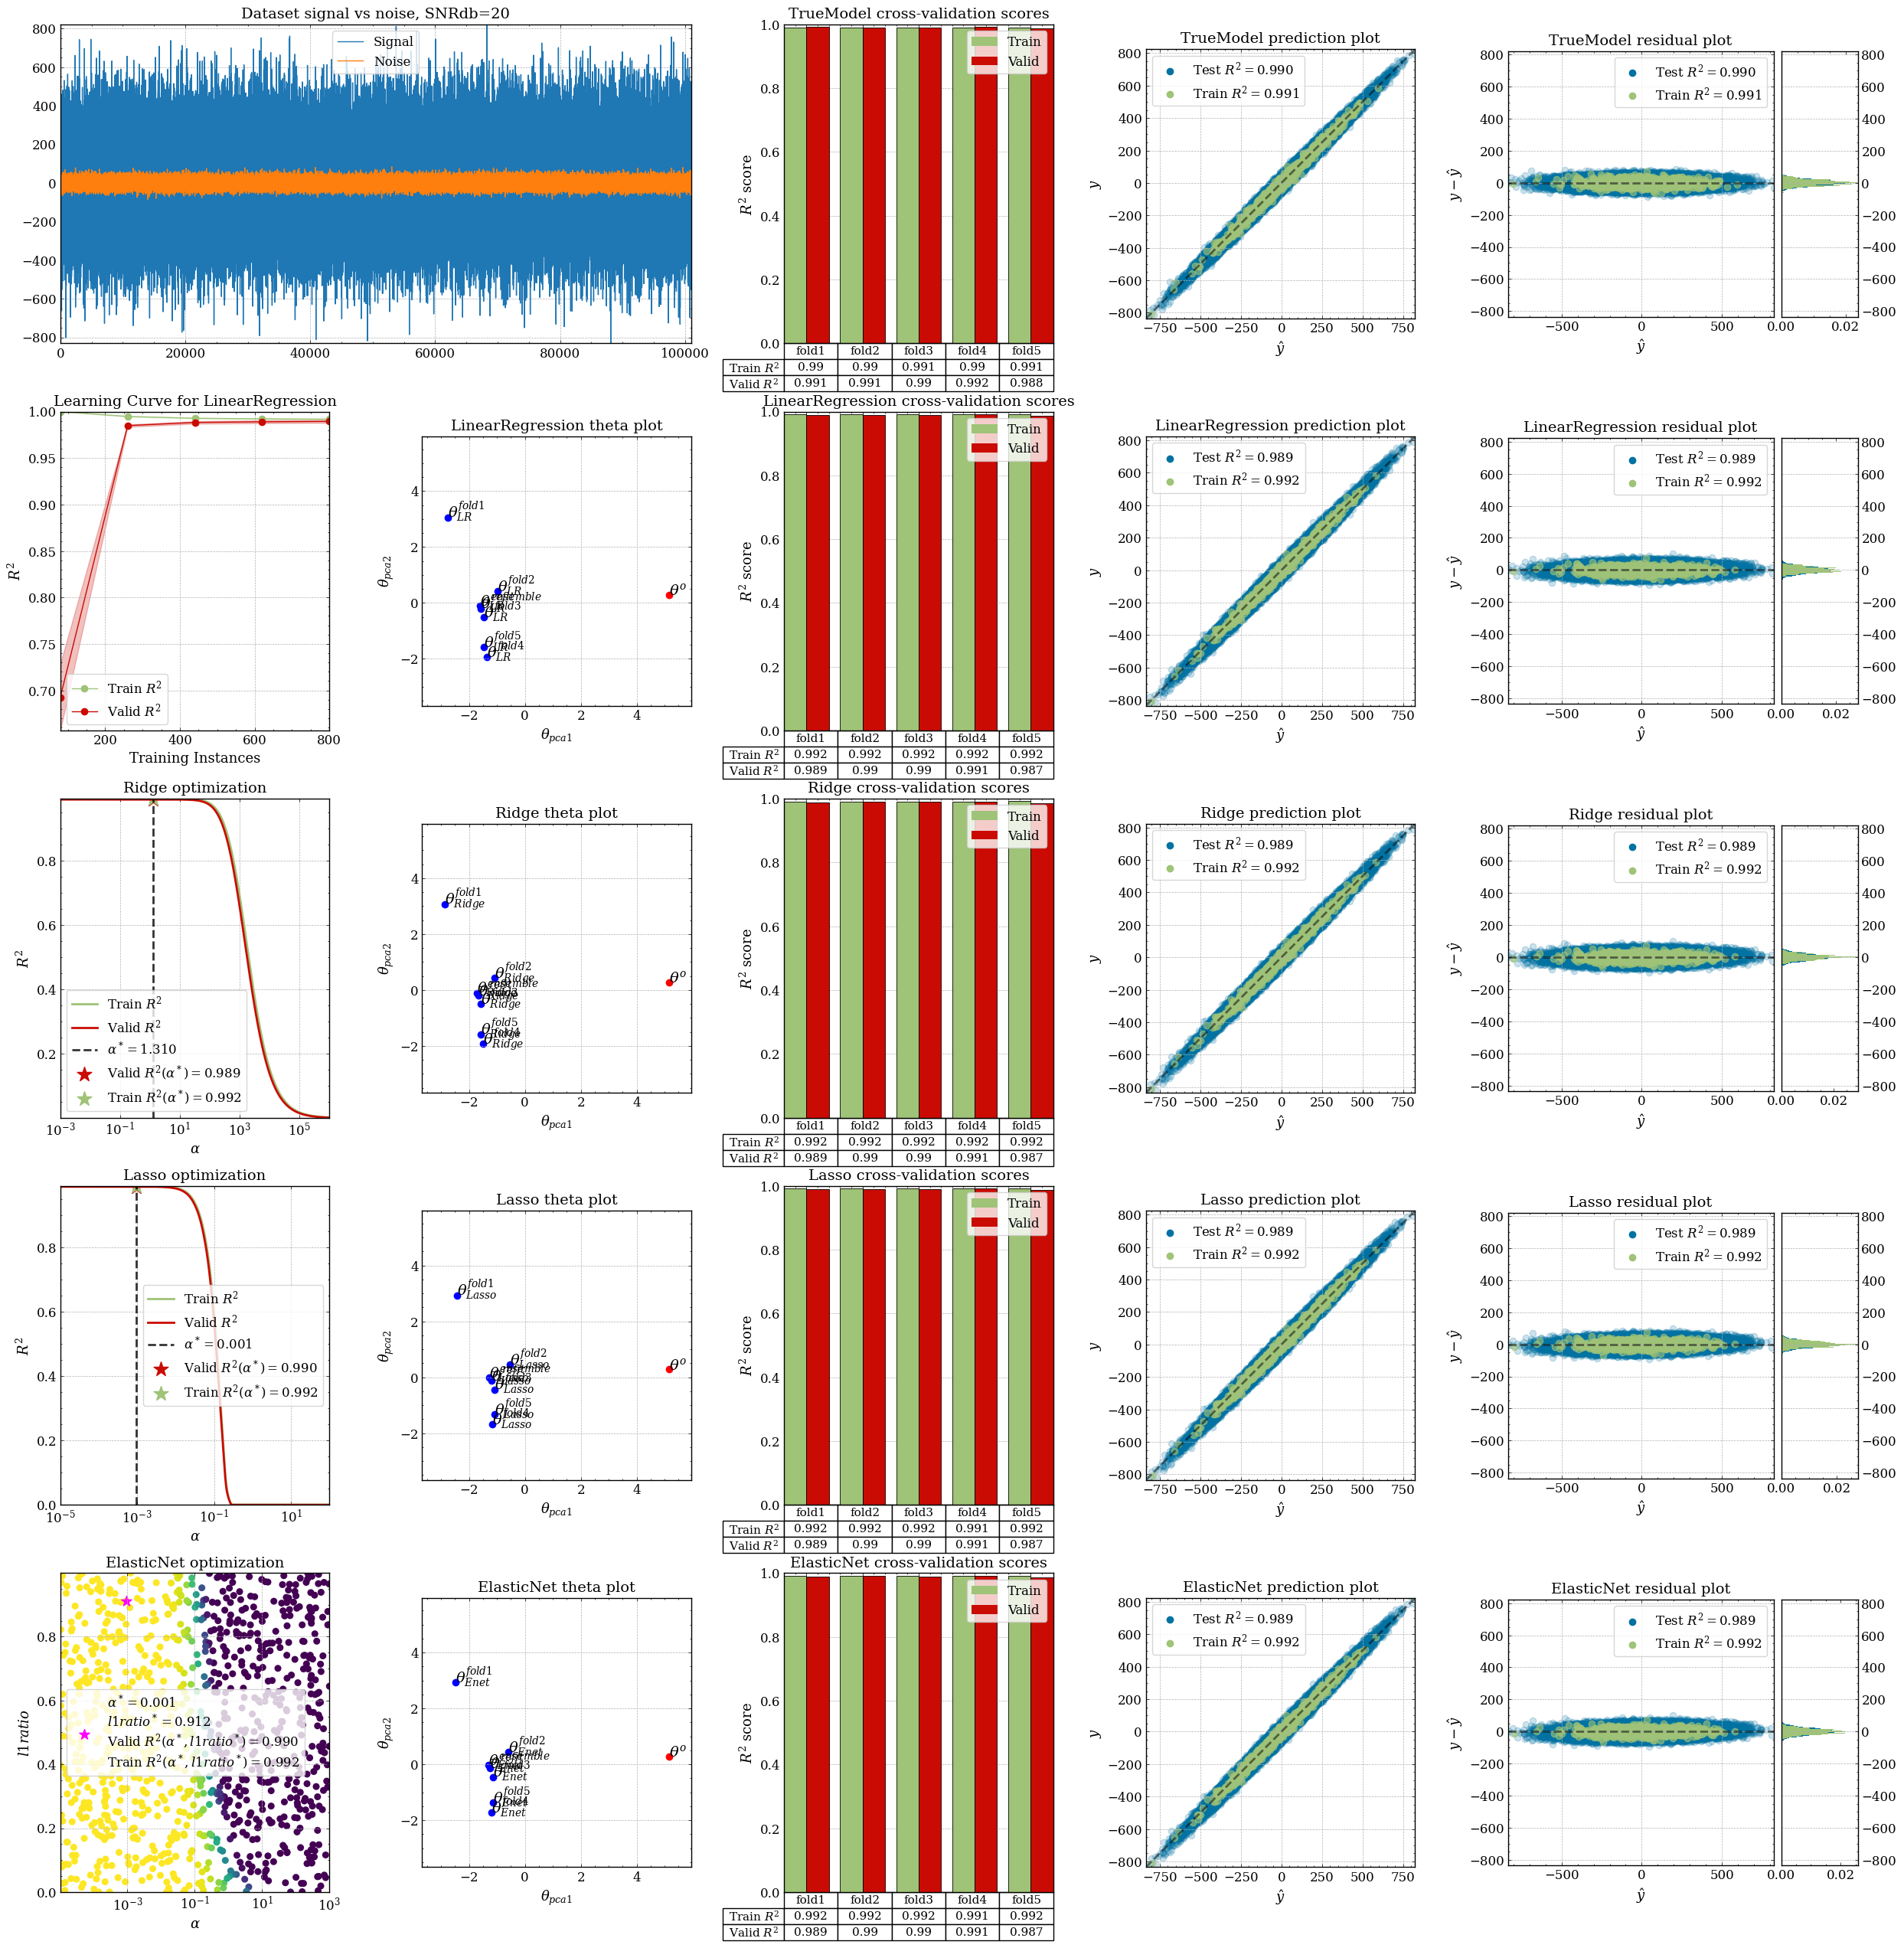

In [8]:
if not sys.warnoptions:
    warnings.simplefilter('ignore')
    os.environ["PYTHONWARNINGS"] = 'ignore'

for i, exp in exp_df.iterrows():
    EXP_ID = exp.exp_id
    SEED = exp.seed
    if exp.torch_dtype == 64:
        DTYPE = torch.float64
    elif exp.torch_dtype == 32:
        DTYPE = torch.float32
    N = exp.samples_number
    D = exp.features_number
    SNR_DB = exp.snr_db
    INFORMATIVE_FRAC = exp.informative_frac
    NUM_FOLDS = exp.folds_number
    INITIALIZATION = exp.initialization
    EPOCHS = exp.epochs_number
    LEARNING_RATE = exp.learning_rate
    
    ### Create output folders
    os.makedirs(os.path.join('..', 'results', 'baselines', FILENAME.split('.')[0], 'data'), exist_ok=True)
    data_folder = os.path.join('..', 'results', 'baselines', FILENAME.split('.')[0], 'data')
    os.makedirs(os.path.join('..', 'results', 'baselines', FILENAME.split('.')[0], 'images'), exist_ok=True)
    images_folder = os.path.join('..', 'results', 'baselines', FILENAME.split('.')[0], 'images')
    
    ### Data generation
    train, test, features, target, theta_true = generate_synthetic_dataset(n_samples_train=N, n_samples_test=100000, n_features=D, n_informative=int(D*INFORMATIVE_FRAC),
                                                                           snr_db=SNR_DB, random_state=SEED)
    check_snr(train, test, features, target, theta_true, snr_db=SNR_DB)
    
    ### Cross-validation strategy
    folds = create_folds(train, features, target, num_folds=NUM_FOLDS, shuffle=True, seed=SEED)
    
    ### Baselines optimization
    base_opt_results, models = optimize_baselines(train, features, target, folds, estimators=['TrueModel', 'LinearRegression', 'Ridge', 'Lasso', 'ElasticNet'],
                                                  normalize=True, true_coef=theta_true, grid_size=grid_size, n_jobs=n_jobs, seed=SEED)
    
    ### Baselines results
    base_results, base_theta = compute_baselines_results(train, test, features, target, theta_true, folds, models, metrics={'r2': r2_score, 'mse': mean_squared_error})
    results_dict = {'exp_id': EXP_ID, 'base_opt_results': base_opt_results, 'models': models, 'base_results': base_results, 'base_theta': base_theta}
    
    with open(os.path.join(data_folder, f'{EXP_ID}.pickle'), 'wb') as handle:
        pickle.dump(results_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    ### Plot dashboard
    pathfile = os.path.join(images_folder, EXP_ID)
    fig_params = {'train_color': "#9fc377", 'test_color': "#0272a2", 'valid_color': "#ca0b03"}
    metric_params = {'metric': 'r2', 'metric_func': r2_score, 'metric_label': '$R^2$'}
    plot_monitoring_dashboard(train, test, features, target, theta_true, folds, base_opt_results, models, base_results, base_theta, fig_params, metric_params, seed=SEED,
                              savefig=pathfile, show=True)